Bachelor Data Extraction & Modeling
===

This notebook uses `requests` and `BeautifulSoup` to extract call-out (Rose Order) data for the contestants on The Bachelor, a popular American reality television series.

I also fit ML models to rank Bachelor contestants based on their rose order in Week 1. Specifically, I tried fitting a linear regression model (both univariate and polynomial), which (as expected) predicted exactly Rose Order.  Then, I fit a default-parameter Gradient Boosting regression model, which did provide a slightly different ordering, and that I used for predicting order on Australia's Bachelor (Matty J.'s season).

In [93]:
import requests
import bs4
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sklearn

### Explore the structure of the wiki pages and use BeautifulSoup to extract and structure the data

In [8]:
r = requests.get("https://bachelor-nation.fandom.com/wiki/The_Bachelor_(Season_22)")

In [14]:
soup = bs4.BeautifulSoup(r.text, 'html.parser')
tables = soup.find_all('table', class_='wikitable')
len(tables)

2

In [19]:
table = tables[0]
ths = table.find_all('th')
[th.text.strip() for th in ths]

['Week', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

In [21]:
print(tds)

[<td bgcolor="tomato" rowspan="8">Ali<br/>Amber<br/>Bri<br/>Brittane J.<br/>Jessica<br/>Lauren J.<br/>Nysha<br/>Olivia
</td>, <td bgcolor="darkgray" colspan="9" rowspan="9">
</td>]


In [34]:
'br' in str(tds[0])

True

In [52]:
r = requests.get("https://bachelor-nation.fandom.com/wiki/The_Bachelor_(Season_22)")
soup = bs4.BeautifulSoup(r.text, 'html.parser')
tables = soup.find_all('table', class_='wikitable')
table = tables[0]

In [53]:
d = []
for rose_order, tr in enumerate(table.find_all('tr')):
    tds = tr.find_all('td')
    if not tds:
        continue
    for week, td in enumerate(tds):
        for line in td.findAll(text=True):
            name = line.strip()
            if name != "":
                d.append({
                    'rose_order': rose_order,
                    'week': week,
                    'contestant': name
                })
        #td_str = str(td)
        #if "<br/>" in td_str:
        #    for name in td_str.split("<br/>"):
        #        print(week, name)
        #else:
        #    name = td.text.strip()
        #    print(week, name)
        
len(d) 

122

In [54]:
df = pd.DataFrame(d)
len(d)

122

In [73]:
df['rose_order'] -= 2

In [74]:
df.head()

,contestant,rose_order,week
0,Rachel,0,0
1,Corinne,0,1
2,Danielle L.,0,2
3,Danielle L.,0,3
4,Rachel,0,4


In [75]:
contestants = df.groupby('contestant')

In [81]:
contestants = []
final_week = np.max(df.week)
for contestant, group in df.groupby('contestant'):
    
    week_eliminated = np.max(group.week)
    if week_eliminated == final_week and group[group.week == final_week].iloc[0].rose_order == 0:
        # this is a special case for the winner, who we consider to be eliminated 
        week_eliminated += 1
    week0_rose_order = group[group.week == 0].iloc[0].rose_order
    contestants.append({
        'season': season,
        'contestant': contestant, 
        'week_eliminated': week_eliminated, 
        'week0_rose_order': week0_rose_order
             })
len(d)

30

### Parse and create dataframe

Now that we have a process that works, we'll load in data for seasons 14-23.

In [90]:
# load the data for many seasons at once
contestants = []
for season in [14, 15, 16, 17, 18, 19, 20, 21, 22, 23]:
    print(f"Season {season}")
    r = requests.get(f"https://bachelor-nation.fandom.com/wiki/The_Bachelor_(Season_{season})")
    soup = bs4.BeautifulSoup(r.text, 'html.parser')
    tables = soup.find_all('table', class_='wikitable')
    table = tables[0]

    d = []
    for rose_order, tr in enumerate(table.find_all('tr')):
        tds = tr.find_all('td')
        if not tds:
            continue
        for week, td in enumerate(tds):
            for line in td.findAll(text=True):
                name = line.strip()
                if name != "":
                    d.append({
                        'rose_order': rose_order,
                        'week': week,
                        'contestant': name
                    })
    df = pd.DataFrame(d)
    print(f"Extracted data for {len(df)} contestants.")
    df['rose_order'] -= 2
    
    final_week = np.max(df.week)
    for contestant, group in df.groupby('contestant'):

        week_eliminated = np.max(group.week)
        is_winner = False
        if week_eliminated == final_week and group[group.week == final_week].iloc[0].rose_order == 0:
            # this is a special case for the winner, who we consider to be eliminated 
            week_eliminated += 1
            is_winner = True
        if 0 not in set(group.week):
            # ignore late-joining contestants
            continue
        week0_rose_order = group[group.week == 0].iloc[0].rose_order
        contestants.append({
            'season': season,
            'contestant': contestant, 
            'week_eliminated': week_eliminated, 
            'week0_rose_order': week0_rose_order,
            'is_winner': is_winner
                 })
len(contestants)

Season 14
Extracted data for 100 contestants.
Season 15
Extracted data for 145 contestants.
Season 16
Extracted data for 133 contestants.
Season 17
Extracted data for 135 contestants.
Season 18
Extracted data for 107 contestants.
Season 19
Extracted data for 122 contestants.
Season 20
Extracted data for 115 contestants.
Season 21
Extracted data for 122 contestants.
Season 22
Extracted data for 122 contestants.
Season 23
Extracted data for 157 contestants.


281

In [91]:
df = pd.DataFrame(contestants)
len(df)

281

In [92]:
df[df.is_winner]

,contestant,is_winner,season,week0_rose_order,week_eliminated
24,Vienna,True,14,10,9
32,Emily,True,15,27,11
61,Courtney,True,16,23,11
85,Catherine,True,17,9,11
128,Nikki,True,18,2,10
162,Whitney,True,19,19,10
180,Lauren B.,True,20,1,10
219,Vanessa,True,21,1,10
225,Becca K.,True,22,1,10
258,Cassie,True,23,8,11


### Modeling

Using sklearn.

In [120]:
# create a polynomial term for use in modeling
df['week0_poly'] = df.week0_rose_order ** 2

In [137]:
# by 
sdf = df[df.week_eliminated >= 1]
len(sdf)

240

In [121]:
import sklearn.linear_model
md = sklearn.linear_model.LinearRegression()
#md.fit(df.week0_rose_order.to_numpy().reshape((len(df), 1)), df.week_eliminated)
md.fit(df[['week0_rose_order', 'week0_poly']], df.week_eliminated)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [146]:
import sklearn.ensemble
md = sklearn.ensemble.GradientBoostingRegressor()
md.fit(sdf.week0_rose_order.to_numpy().reshape((len(sdf), 1)), sdf.week_eliminated)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [147]:
week_pred = md.predict(sdf.week0_rose_order.to_numpy().reshape((len(sdf), 1)))

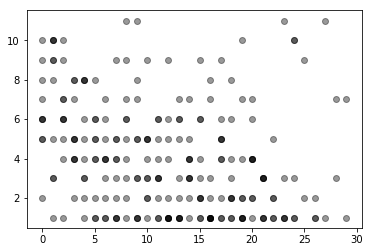

In [148]:
plt.scatter(sdf.week0_rose_order, sdf.week_eliminated, alpha=0.4, color='black')
plt.show()

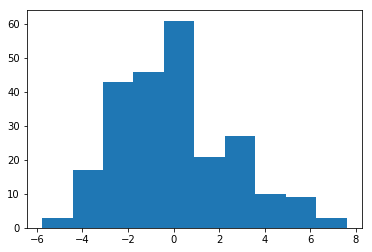

In [149]:
plt.hist(sdf.week_eliminated - week_pred)
plt.show()

In [143]:
# what predictions does the model make given starting positions?
md.predict(np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]).reshape((16, 1)))

array([ 6, 10,  6,  5,  8,  4,  4,  1,  6,  1,  5,  3,  1,  1,  4,  2])

### Predict on a specific list of names

From Matty J.'s season on Bachelor Australia.

In [133]:
names="""
Michelle
Lisa
Laura
Alix
Elora
Cobie
Elise
Tara
Simone
Laura-Ann
Akoulina
Leah
Sian
Florence
Stephanie
Natalie
Belinda
Jennifer
Sharlene
Elizabeth"""
mattyj_contestants = [name for name in names.split("\n") if name != ""]
mattyj_contestants

['Michelle',
 'Lisa',
 'Laura',
 'Alix',
 'Elora',
 'Cobie',
 'Elise',
 'Tara',
 'Simone',
 'Laura-Ann',
 'Akoulina',
 'Leah',
 'Sian',
 'Florence',
 'Stephanie',
 'Natalie',
 'Belinda',
 'Jennifer',
 'Sharlene',
 'Elizabeth']

In [134]:
week0_order = list(range(len(mattyj_contestants)))
week0_order

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [124]:
poly = [order**2 for order in week0_order]

In [151]:
preds = md.predict(np.array(week0_order).reshape((len(week0_order), 1)))
preds

array([6.39504283, 6.76627139, 6.0926128 , 5.19424755, 4.79566722,
       4.20552841, 3.71925075, 3.54993528, 5.32746757, 4.50194716,
       3.893049  , 3.39379717, 3.20745426, 3.28713705, 3.55931024,
       3.55931024, 2.69587863, 4.12419973, 3.27074119, 3.27074119])

In [153]:
scored = list(zip(preds, mattyj_contestants))
scored.sort(key=lambda t: t[0], reverse=True)
scored

[(6.766271391004401, 'Lisa'),
 (6.395042826236096, 'Michelle'),
 (6.092612797376015, 'Laura'),
 (5.327467574825978, 'Simone'),
 (5.19424755380423, 'Alix'),
 (4.795667221431778, 'Elora'),
 (4.501947155467457, 'Laura-Ann'),
 (4.205528410889004, 'Cobie'),
 (4.1241997342924055, 'Jennifer'),
 (3.893048997786078, 'Akoulina'),
 (3.7192507548807674, 'Elise'),
 (3.559310235826028, 'Stephanie'),
 (3.559310235826028, 'Natalie'),
 (3.5499352801474755, 'Tara'),
 (3.3937971695970446, 'Leah'),
 (3.28713705032877, 'Florence'),
 (3.270741193686432, 'Sharlene'),
 (3.2707411936864315, 'Elizabeth'),
 (3.207454263615432, 'Sian'),
 (2.695878634372921, 'Belinda')]

In [155]:
for t in scored:
    print(t[1])

Lisa
Michelle
Laura
Simone
Alix
Elora
Laura-Ann
Cobie
Jennifer
Akoulina
Elise
Stephanie
Natalie
Tara
Leah
Florence
Sharlene
Elizabeth
Sian
Belinda


In [58]:
week_eliminated = df.groupby('contestant').max().week

In [59]:
week_eliminated

contestant
Alexis         4
Angela         0
Astrid         3
Briana         0
Brittany       2
Christen       2
Corinne        6
Danielle L.    5
Danielle M.    5
Dominique      2
Elizabeth      1
Hailey         1
Ida Marie      0
Jaimi          4
Jasmine B.     0
Jasmine G.     5
Josephine      4
Kristina       5
Lacey          1
Lauren         0
Liz            1
Michelle       0
Olivia         0
Rachel         8
Raven          9
Sarah          3
Susannah       0
Taylor         4
Vanessa        9
Whitney        5
Name: week, dtype: int64

In [63]:
df[df.week == 0]

,contestant,rose_order,week
0,Rachel,2,0
10,Vanessa,3,0
20,Danielle L.,4,0
32,Christen,5,0
39,Astrid,6,0
45,Corinne,7,0
51,Elizabeth,8,0
57,Jasmine G.,9,0
63,Raven,10,0
69,Kristina,11,0
